## Experiment Setup

###  Random seed / Colab / CUDA related

In [1]:
import time
import datetime
import os
import sys
import itertools

# Use Google Colab
use_colab = True

# Is this notebook running on Colab?
# If so, then google.colab package (github.com/googlecolab/colabtools)
# should be available in this environment

# Previous version used importlib, but we could do the same thing with
# just attempting to import google.colab
try:
    from google.colab import drive
    colab_available = True
except:
    colab_available = False

if use_colab and colab_available:
    drive.mount('/content/drive')
    
    # If there's a package I need to install separately, do it here
    !pip install pyro-ppl

    # cd to the appropriate working directory under my Google Drive
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    
    # List the directory contents
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
random_seed = 682

### Third party libraries (NumPy, PyTorch, Pyro)

In [2]:
# Third party libraries import
import numpy as np
import torch
import pyro
import matplotlib.pyplot as plt

# Print version information
print("Python Version: " + sys.version)
print("NumPy Version: " + np.__version__)
print("PyTorch Version: " + torch.__version__)
print("Pyro Version: " + pyro.__version__)

Python Version: 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
NumPy Version: 1.17.2
PyTorch Version: 1.3.1
Pyro Version: 1.0.0


In [3]:
# More imports...
from torch import nn, optim
from torch.utils.data import random_split, DataLoader, RandomSampler
import torchvision
import torchvision.transforms as transforms
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC

# Import model and dataset classes from ronald_bdl
from ronald_bdl import models, datasets
from ronald_bdl.models import utils

# pyplot setting
%matplotlib inline

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')

    torch.backends.cudnn.deterministic = True
    # Disable 'benchmark' mode
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory = True # Faster Host to GPU copies with page-locked memory

    # CUDA libraries version information
    print("CUDA Version: " + str(torch.version.cuda))
    print("cuDNN Version: " + str(torch.backends.cudnn.version()))
    print("CUDA Device Name: " + str(torch.cuda.get_device_name()))
    print("CUDA Capabilities: "+ str(torch.cuda.get_device_capability()))
else:
    torch_device = torch.device('cpu')
    use_pin_memory = False

### Toy dataset settings

In [4]:
"""
Toy dataset generation based on the experiment from 
the Probabilstic Backpropagation paper (Hernandez-Lobato & Adams, 2015)
"""

# Random seed for toy dataset
dataset_toy_random_seed = 691

# Toy dataset size
dataset_toy_size = 20

# Toy dataset x distribution (uniform) parameters
dataset_toy_x_low = -4
dataset_toy_x_high = 4

# Toy dataset y distribution (normal with noise)
dataset_toy_y_mean = 0
dataset_toy_y_std = 9

### MC dropout parameters

In [5]:
"""
MC Dropout related
"""

# Dropout rate
dropout_rate = 0.1

# Length scale
length_scale = 1e-2

# tau
tau = 0.5

# reg strength
reg_strength = utils.reg_strength(dropout_rate, length_scale, dataset_toy_size, tau)

print('reg_strength = ' + str(reg_strength))

# Epochs
n_epochs = 4000

# Optimizer learning rate
learning_rate = 0.001

# Loss function type
loss_function_type = 'mse_loss'

# Number of test predictions (for each data point)
n_predictions = 1000

reg_strength = tensor(4.5000e-06)


### Directory path to save results

In [6]:
# Test start time
test_start_time = datetime.datetime.today().strftime('%Y%m%d%H%M')

# Directory to store the results for this experiment
test_results_path = os.path.join(
    './test_results',
    'comparison_toy',
    (
        test_start_time 
        + '_' + str(n_epochs) 
        + '_' + str(dropout_rate) 
        + '_' + str(length_scale)
        + '_' + str(tau)
        + '_' + str(loss_function_type) 
        + '_' + str(n_predictions))
)

# Create the directory if it doesn't exist
os.makedirs(test_results_path, exist_ok=True)

## Prepare data

### Get the data as a torch Dataset object

In [7]:
dataset = datasets.ToyDatasets(
    random_seed=dataset_toy_random_seed,
    n_samples=dataset_toy_size,
    x_low=dataset_toy_x_low,
    x_high=dataset_toy_x_high,
    y_mean=dataset_toy_y_mean,
    y_std=dataset_toy_y_std,
)

# Get the test data
X_test = torch.linspace(dataset_toy_x_low, dataset_toy_x_high, 100).reshape(100, 1)

# Send it to the memory of the device to be used for training
X_test = X_test.to(torch_device)

# Save a copy at CPU for plotting
X_test_cpu = X_test.cpu()

# Print the size of the training set
print("dataset size = " + str((len(dataset), dataset.n_features)))

dataset size = (20, 1)


## Declare models

In [8]:
uncertainty_methods = {}

# MC (Bernoulli) dropout
do_mc_dropout = True

if do_mc_dropout:
    uncertainty_methods['mc_dropout'] = models.FCNet(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
    )
    
    uncertainty_methods['mc_dropout_tanh'] = models.FCNet(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
        nonlinear_type='tanh',
    )
    
    uncertainty_methods['mc_dropout_sigmoid'] = models.FCNet(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=dropout_rate,
        dropout_type='bernoulli',
        nonlinear_type='sigmoid',
    )

# Vanilla Variational Inference
do_vi = False

if do_vi:
    uncertainty_methods['vi'] = models.FCNetPyro(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        torch_device=torch_device,
    )

# HMC
do_hmc = False

if do_hmc:
    uncertainty_methods['hmc'] = models.FCNetPyro(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        torch_device=torch_device,
    )

## Train the models

### Train/test the model

In [9]:
for key, network in uncertainty_methods.items():
    # Reset the random number generator for each method (to produce identical results)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    pyro.set_rng_seed(random_seed)
    
    # Print the method name
    print("Now running " + str(key))
    
    # Send the whole model to the selected torch.device
    network.to(torch_device)

    # Print the network structure
    print(network)
    print()

    # Initialize training data loader
    train_loader = DataLoader(dataset, batch_size=128)
    
    """
    Optimizer Setup
    """

    if isinstance(network, models.FCNet):
        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = torch.optim.Adam(
            network.parameters(),
            lr=learning_rate,
            weight_decay=reg_strength, # L2 regularization
        )

        # Mean Squared Error for loss function to minimize
        objective = torch.nn.MSELoss()

    elif isinstance(network, models.FCNetPyro):
        # Clear everything in Pyro parameter storage
        # Looks like this parameter store would be globally shared across
        # models in the same Python instance.
        pyro.clear_param_store()

        # Force all the PyTorch tensors to be CUDA tensors if available
        if use_cuda and torch.cuda.is_available():
            torch.set_default_tensor_type(torch.cuda.FloatTensor)

        # Different optimizers for VI and HMC
        if key == 'vi':
            optimizer = pyro.optim.Adam({"lr": 0.01})
            svi = SVI(network, network.guide, optimizer, loss=Trace_ELBO())
        elif key == 'hmc':
            kernel = HMC(network)
            mcmc = MCMC(kernel, num_samples=10000)

    """
    Training
    """

    # Model to train mode
    network.train()

    # Record training start time (for this method)
    tic = time.time()
    
    if key == 'hmc':
        # to() actually returns new Tensor; need to replace with that return
        dataset.data_x = dataset.data_x.to(torch_device)

        dataset.data_y = dataset.data_y.to(torch_device)

        mcmc.run(dataset.data_x, dataset.data_y)
    else:
        for epoch in range(n_epochs): # loop over the dataset multiple times

            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, targets = data

                # Store the batch to torch_device's memory
                # to() actually returns new Tensor; need to replace with that return
                inputs = inputs.to(torch_device)
                targets = targets.to(torch_device)

                if isinstance(network, models.FCNet):
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward + backward + optimize
                    outputs = network(inputs)

                    total_loss = objective(outputs, targets)

                    total_loss.backward()

                    optimizer.step()

                elif isinstance(network, models.FCNetPyro):
                    pyro.clear_param_store()
                    # calculate the loss and take a gradient step
                    total_loss = svi.step(inputs, targets)

            if epoch % 100 == 0:
                print("[iteration %04d] loss: %.4f" % (epoch + 1, total_loss))
            
    # Record training end time
    toc = time.time()

    # Report the final loss
    print("final loss = " + str(total_loss))            

    # Report the total training time
    print("training time = " + str(toc - tic) + " seconds")
    
    print()

Now running mc_dropout
FCNet(
  (input): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=1, out_features=100, bias=True)
    (nonlinear): ReLU()
  )
  (output): ModuleDict(
    (dropout): Dropout(p=0.1, inplace=False)
    (linear): Linear(in_features=100, out_features=1, bias=True)
  )
)

[iteration 0001] loss: 585.1613
[iteration 0101] loss: 341.5176
[iteration 0201] loss: 232.0521
[iteration 0301] loss: 174.8347
[iteration 0401] loss: 234.5388
[iteration 0501] loss: 175.1985
[iteration 0601] loss: 163.4085
[iteration 0701] loss: 163.7288
[iteration 0801] loss: 167.1473
[iteration 0901] loss: 149.5962
[iteration 1001] loss: 176.4000
[iteration 1101] loss: 135.7911
[iteration 1201] loss: 171.1487
[iteration 1301] loss: 258.6693
[iteration 1401] loss: 122.1155
[iteration 1501] loss: 150.5122
[iteration 1601] loss: 184.7321
[iteration 1701] loss: 114.3946
[iteration 1801] loss: 127.1016
[iteration 1901] loss: 96.6620
[iteration 2001] loss: 98.313

## Plot the results

testing time = 0.10597610473632812 seconds

Mean = tensor([-46.4370, -45.8748, -43.5808, -41.1280, -39.2306, -37.5926, -37.3440,
        -35.6154, -33.3410, -31.7108, -30.8394, -28.9495, -26.8713, -25.6194,
        -23.8589, -22.5140, -20.6880, -19.0037, -17.2483, -15.8594, -14.2364,
        -12.6115, -10.7759,  -9.5364,  -8.2753,  -6.7383,  -5.3990,  -3.9157,
         -3.5579,  -3.3084,  -2.9990,  -2.7082,  -2.4068,  -2.1437,  -1.8367,
         -1.5201,  -1.3011,  -1.0283,  -0.8055,  -0.6186,  -0.4395,  -0.2317,
         -0.0690,   0.0991,   0.2823,   0.4824,   0.6715,   0.8465,   1.0343,
          1.2197,   1.3535,   1.4122,   1.4858,   1.5405,   1.5504,   1.6386,
          1.6570,   1.7199,   1.7085,   1.7548,   1.7688,   1.8560,   1.8868,
          1.8741,   1.9532,   1.9385,   2.0003,   2.0269,   2.1231,   2.7100,
          3.4783,   4.3097,   5.1540,   5.9849,   6.7549,   7.6579,   8.3083,
          9.2022,  10.2595,  11.1189,  12.6260,  14.2596,  16.1875,  17.7582,
         19.4

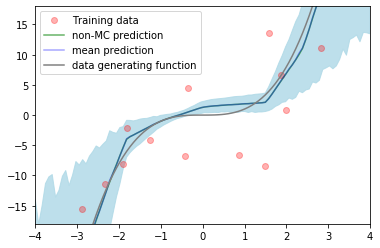

testing time = 0.13223886489868164 seconds

Mean = tensor([-46.3512, -44.1634, -42.9082, -42.3525, -41.5532, -39.2261, -38.1371,
        -36.4098, -34.7758, -33.1554, -30.9229, -29.3137, -27.7819, -25.3181,
        -22.7594, -21.5037, -19.6459, -18.0486, -16.4344, -14.7578, -13.4372,
        -11.9793, -10.9269,  -9.5997,  -8.3339,  -7.3036,  -6.4005,  -5.6554,
         -4.9908,  -4.1909,  -3.8207,  -3.1342,  -2.4666,  -2.2690,  -1.9365,
         -1.4698,  -1.2145,  -0.8179,  -0.6439,  -0.3180,  -0.1866,   0.1435,
          0.1497,   0.3254,   0.5209,   0.7639,   0.8543,   0.8650,   0.9719,
          1.0504,   1.2445,   1.2350,   1.2818,   1.4251,   1.4868,   1.6785,
          1.7627,   1.7938,   1.9708,   1.9878,   2.1284,   2.1857,   2.4344,
          2.4883,   2.7994,   2.9681,   3.1099,   3.3646,   3.7233,   4.0629,
          4.2397,   4.6388,   5.1827,   5.6113,   6.0916,   6.6592,   7.3229,
          8.2264,   9.2275,  10.3940,  11.1404,  12.3669,  13.5287,  15.2393,
         17.1

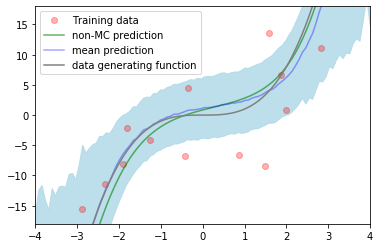

testing time = 0.11240887641906738 seconds

Mean = tensor([-29.3393, -29.7683, -28.7362, -28.2473, -28.2119, -27.5336, -27.2055,
        -26.6703, -25.4068, -25.3097, -24.3830, -23.6717, -23.3572, -22.5538,
        -22.1705, -21.6553, -20.2741, -19.4026, -19.2681, -18.2627, -17.1835,
        -16.6667, -15.8975, -15.0713, -14.5534, -13.7943, -13.3982, -12.3563,
        -11.8832, -11.3598, -10.7310,  -9.7910,  -9.4652,  -8.9700,  -8.3509,
         -7.6996,  -7.2691,  -6.6624,  -6.1656,  -5.7070,  -5.2029,  -4.6523,
         -4.1685,  -3.6348,  -3.2433,  -2.6992,  -2.2033,  -1.7195,  -1.1211,
         -0.7668,  -0.2860,   0.2421,   0.8052,   1.3188,   1.7343,   2.2864,
          2.8271,   3.3203,   3.7819,   4.3401,   4.9125,   5.3167,   6.2189,
          6.6440,   7.1695,   8.0234,   8.5120,   9.1556,   9.9079,  10.5634,
         11.1360,  11.7987,  12.4798,  13.5319,  13.6477,  14.8771,  15.4640,
         16.0982,  17.0485,  18.0710,  18.6292,  19.3945,  20.0683,  20.9136,
         22.0

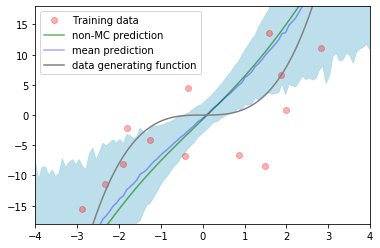

In [10]:
for key, network in uncertainty_methods.items():

    """
    Testing
    """

    # Model to eval mode
    network.eval()

    # Record testing start time (for this split)
    tic_testing = time.time()
    
    predictions_non_mc = network(X_test)

    predictions, mean, var, metrics = network.predict_dist(X_test, n_predictions)
    
    # Record testing end time
    toc_testing = time.time()
    
    # Report the total testing time
    print("testing time = " + str(toc_testing - tic_testing) + " seconds")

    # These can now be stored in CPU memory for plotting
    predictions_non_mc = predictions_non_mc.cpu()
    predictions = predictions.cpu()
    mean = mean.cpu()
    var = var.cpu()
    
    """
    Print results
    """

    print()
    print("Mean = " + str(mean.flatten()))
    print("Variance = " + str(var.flatten()))
    
    # store additional metrics
    if len(metrics) > 0:
        for key, value in metrics.items():
            print(str(key) + " = " + str(value))
        print()
             
    # Plot the uncertainty measured by each methods
    plt.figure()
    
    # Fix the scales of x-axis and y-axis
    plt.xlim(dataset_toy_x_low, dataset_toy_x_high)
    plt.ylim(dataset_toy_y_mean-2*dataset_toy_y_std, dataset_toy_y_mean+2*dataset_toy_y_std)

    # Distributions around the predictions
    plt.fill_between(
        X_test_cpu.flatten(), 
        (mean.detach().numpy() - 2*torch.sqrt(var).detach().numpy()).flatten(),
        (mean.detach().numpy() + 2*torch.sqrt(var).detach().numpy()).flatten(),
        color='lightblue', alpha=0.8)

    # Train data
    plt.plot(dataset.data_x.cpu(), dataset.data_y.cpu(), 'or', label='Training data', alpha=0.3)

    # Non-MC prediction
    plt.plot(X_test_cpu, predictions_non_mc.detach().numpy(), 'green', label='non-MC prediction', alpha=0.6)    
    
    # MC prediction
    plt.plot(X_test_cpu, mean.detach().numpy(), 'blue', label='mean prediction', alpha=0.35)
    
    # Original data generating function without noise
    plt.plot(X_test_cpu, X_test_cpu ** 3, 'gray', label='data generating function')    
    
    plt.legend()
    
    plt.savefig(os.path.join(test_results_path, str(key) + '.png'), dpi=600)
    
    plt.show()